In [1]:
import os
import time
import datetime
import itertools

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dateutil.relativedelta import relativedelta
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

# Load shapefiles 

In [2]:
# cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# CVW shapefile 
cvws = gp.read_file("../shape/cvws.shp")

# grace footprint
grace_sa = gp.read_file("../shape/argus_grace.shp")

# Casgem wells 
casgem = gp.read_file("../shape/casgem_wells.shp")
casgem.crs = {'init': 'epsg:4326'}
casgem = gp.sjoin(casgem,cvsa, op ='within')

# Stream gauges
gauges = gp.read_file("../shape/usgs_gauges.shp")
stations_in = [11446500, 11376550, 11423800, 11384000, 11390000 ,11451760,
            11372000, 11335000, 11376000, 11374000, 11383500, 11329500,
            11211300, 11424500, 11379500, 11407150, 11257500, 11209900,
            11192950, 11251600, 11225000, 11270900, 11381500, 11221700,
            11325500, 11384350, 11454000, 11370500, 11251000, 11302000, 
            11388000, 11382000, 11289650, 11199500, 11421000, 
            11208818, 11204100, 11200800, 11218400, 11289000, 11323500]

st_in = [str(x) for x in stations_in]
inflow = gauges[gauges['gauge_id'].isin(st_in)]

# Load outflow
outflow = gp.read_file('../shape/outflow.shp')

# Reservoirs
reservoirs = gp.read_file("../shape/reservoirs_grace.shp")

# Load water balance data 

In [3]:
# Load preprocessed RS Data (P, R, SM, SWE)
cvdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat_cv.csv"))
cvwdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat_cvws.csv"))

# Streamflow data (Qs; No inflow to CVWS) 
qs_in = rs.col_to_dt(pd.read_csv("../data/Qs_in_monthly.csv"))
qs_out = rs.col_to_dt(pd.read_csv("../data/Qs_out_monthly.csv"))
qs = rs.col_to_dt(pd.read_csv("../data/net_flow_monthly.csv"))
qs_in.columns = ['qs_in_km3']
qs_out.columns = ['qs_out_km3']
qs.columns = ['qs_net_cv_km3']

# Reservoir Data for CV and CVWS
Sres_cv = rs.col_to_dt(pd.read_csv('../data/cv_Sres.csv'))
Sres_cv.columns = ['Sres_cv']
Sres_cvws = rs.col_to_dt(pd.read_csv('../data/cvws_Sres.csv'))
Sres_cvws.columns = ['Sres_cvws']


In [4]:
# Load ET data processed using crop coefficient method (split into chunks in the ETkc folder)

files = [os.path.join("../data/ETcv",x) for x in os.listdir("../data/ETcv") if x.endswith(".csv")]
etdfs = [pd.read_csv(x) for x in files]

etcvdfs = [x.ETkc for x in etdfs]
petdfs = [x.petimsum for x in etdfs]
aetdfs = [x.aetimsum for x in etdfs]
kcdfs = [x.kc_mean for x in etdfs]

ETcv = pd.concat(etcvdfs, axis = 1)
aet = pd.concat(aetdfs, axis = 1)
pet = pd.concat(petdfs, axis = 1)
kc = pd.concat(kcdfs, axis = 1)

etcvs = ETcv.sum(axis=1)
pets = pet.sum(axis=1)
aets = aet.sum(axis=1)
kcs = kc.mean(axis = 1)

etdf = pd.DataFrame([etcvs, pets, aets, kcs]).T
etdf.index = pd.to_datetime(etdfs[0][etdfs[0].columns[0]])

etdf.columns = ['ETkc', 'pet', 'aet', "kc"]

# Load SSEBop ET data
ssebop_et =  pd.read_csv("../data/ssebop_et.csv")
ssebop_et = rs.col_to_dt(ssebop_et)

# Load Validation data

In [5]:
# Grace data
gracedf = pd.read_csv("../data/grace.csv")
grace = rs.col_to_dt(gracedf)

# Wells data (processed by zihan using Faunt 2009 Sy values )
wells = pd.read_csv('../data/wells_ds.csv')
wells = rs.col_to_dt(wells)

# c2vsim storage data (processed by Rich)
c2vsim_ds = pd.read_csv('../data/c2vsim_ds.csv')
c2vsim_ds = rs.col_to_dt(c2vsim_ds)

In [6]:
cvdf.set_index(cvdf.index + MonthEnd(0), inplace = True)
cvwdf.set_index(cvwdf.index + MonthEnd(0), inplace = True)
etdf.set_index(etdf.index + MonthEnd(0), inplace = True)
ssebop_et.set_index(ssebop_et.index + MonthEnd(0), inplace = True)

In [7]:
if not os.path.exists("../data/WBdata_final.csv"):
    lrm_swe = rs.get_lrm_swe("../shape/cvws.shp", data_dir = "/Users/aakash/Desktop/SierraSheds/data/LRM_SWE_monthly/")
    snodas_swe = rs.get_snodas_swe("../shape/cvws.shp", data_dir ="/Users/aakash/Desktop/SatDat/SNODAS/SNODAS_CA_processed/" )

    wbdf = pd.concat([cvdf,cvwdf, etdf, ssebop_et, lrm_swe, snodas_swe,
                      qs_in, qs_out, Sres_cv, Sres_cvws,
                      grace, wells, c2vsim_ds], axis = 1)
    wbdf['ETkc_cvws'] = wbdf['aet_modis_cvws'] - wbdf['aet_modis'] + wbdf['ETkc'] 
    wbdf['r_gldas_cv'] = wbdf['r_gldas_cvws'] - wbdf['r_gldas']
    wbdf['r_fldas_cv'] = wbdf['r_fldas_cvws'] - wbdf['r_fldas']
    wbdf['r_tc_cv'] = wbdf['r_tc_cvws'] - wbdf['r_tc']

    wbdf.to_csv("../data/WBdata_final.csv")

else:
    wbdf = rs.col_to_dt(pd.read_csv("../data/WBdata_final.csv"))

In [8]:
####### TRIPLE COLLOCATION FUNCTIONS #######

def calc_tc_error(x,y,z):
    '''
    calculate errors between triplets
    '''
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    '''
    scale one dataset to another (mean / std)
    '''
    return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)


def do_tc(df):
    '''
    wrapper for calc_tc_error applied to a df 
    '''
    tc_dict = df.astype(float).to_dict('list')

    combos=combinations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

######## PLOTTING FUNCS #########
    
    
def make_plots(df, coldict, var):
    '''
    for a dataframe of a single variable and a dict mapping col names to datasets, return:
    1) mean annual boxplot, 
    2) mean monthly scatterplot, 
    3) full timeseries, 
    4) correlation plot
    5) Triple collocation error box plot
    '''
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))
    
    plt.figure(figsize=(35,3))
    G = gridspec.GridSpec(9, 12)

    ax1 = plt.subplot(G[:, 0])

    # Boxplot
    df.resample("Y").sum().boxplot(ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60)
    ax1.set_title("Mean Annual")
    ax1.set_ylabel("{} $(mm)$".format(var), size = 20)

    # Monthly mean plot with errs
    ax2 = plt.subplot(G[:,1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B') for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 60)
    ax2.set_title("Mean Monthly")
    
    # Time series 
    ax3 = plt.subplot(G[:,3:-3])
    
    for k,v in cdict.items():
        df[k].plot(ax = ax3,x_compat=True,color = v)

    ax3.xaxis.set_tick_params(reset=True)
    ax3.xaxis.set_major_locator(mdates.YearLocator(1))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.set_xlim([df.index[0],df.index[-1]])
    ax3.set_title("Monthly Time Series")
    leg = ax3.legend(loc='lower left', ncol = len(colors), bbox_to_anchor=(-0.025, -0.55),
               fancybox=True,  prop={'size': 15})

    # Corr mat
    ax4 = plt.subplot(G[:,-3:-2])
    sns.heatmap(df.corr(), ax = ax4, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax4.set_title("Correlation matrix")

    # Tc Ebar
    ax5 = plt.subplot(G[:,-2:-1])
    dropcols = [x for x in df.columns if "Reservoir" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax5)
    ax5.set_xticklabels(ax5.get_xticklabels(),rotation = 60)
    ax5.set_title("Triple Collocation Error")

    plt.tight_layout()
    plt.show()
    
    
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)

    
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    
    
########## TRENDLINE FUNCTIONS ###########
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cvds'][df_mask].values
    rscvws = df['cvwds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict


def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],2) for k,v in d.items()}
    
    return polyfits

# CVWS

In [9]:
pcoldict = {'p_prism_cvws':'PRISM', 
                'p_trmm_cvws':'TRMM',  
                'p_dmet_cvws':'Daymet',
                'p_psn_cvws': "PERSIANN",
                'p_chirps_cvws': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())][323:-12]
pdf.dropna(axis = 0, how = 'all', inplace = True)
pdf.rename(columns = pcoldict, inplace = True)

swecoldict = {'swe_gldas_cvws':'GLDAS', 
                'swe_fldas_cvws':'FLDAS',  
                'swe_dmet_cvws':"Daymet",
                'swe_tc_cvws':'TC',
                'swe_lrm': "UCB LRM",
                'swe_snodas': "SNODAS"}
swedf = wbdf.loc[:, wbdf.columns.isin(swecoldict.keys())][323:-12]
swedf.dropna(axis = 0, how = 'all', inplace = True)
swedf.rename(columns = swecoldict, inplace = True)

aetcoldict = {'aet_gldas_cvws':'GLDAS', 
                'aet_fldas_cvws':'FLDAS',  
                'ETkc_cvws':"ETkc",
                'aet_tc_cvws':'TC',
                'ssebop_cvws': "SSEBop",
                'aet_modis_cvws': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())][323:-12]
aetdf.dropna(axis = 0, how = 'all', inplace = True)
aetdf.rename(columns = aetcoldict, inplace = True)

petcoldict = {'pet_gldas_cvws':'GLDAS', 
                'pet_gmet_cvws':'Gridmet',  
                'pet_tc_cvws':'TC',
                'pet_modis_cvws': "MOD16",
                'pet_nldas_cvws': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())][323:-12]
petdf.dropna(axis = 0, how = 'all', inplace = True)
petdf.rename(columns = petcoldict, inplace = True)

smcoldict = {'sm_smos_cvws':'SMOS', 
                'sm_smap_cvws':'SMAP',  
                'sm_tc_cvws':'TC',
                'sm_gldas_cvws': "GLDAS",
                'Sres_cvws': "Reservoirs"}
smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())][323:-12]
smdf.dropna(axis = 0, how = 'all', inplace = True)
smdf.rename(columns = smcoldict, inplace = True)

rcoldict = {'qs_out_km3':'DWR Qout', 
            'qs_in_km3': 'USGS Qin',
            'r_fldas_cv':'FLDAS',  
            'r_tc_cv':'TC',
            'r_gldas_cv': "GLDAS"}
rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())][323:-12]
rdf.dropna(axis = 0, how = 'all', inplace = True)
rdf.rename(columns = rcoldict, inplace = True)

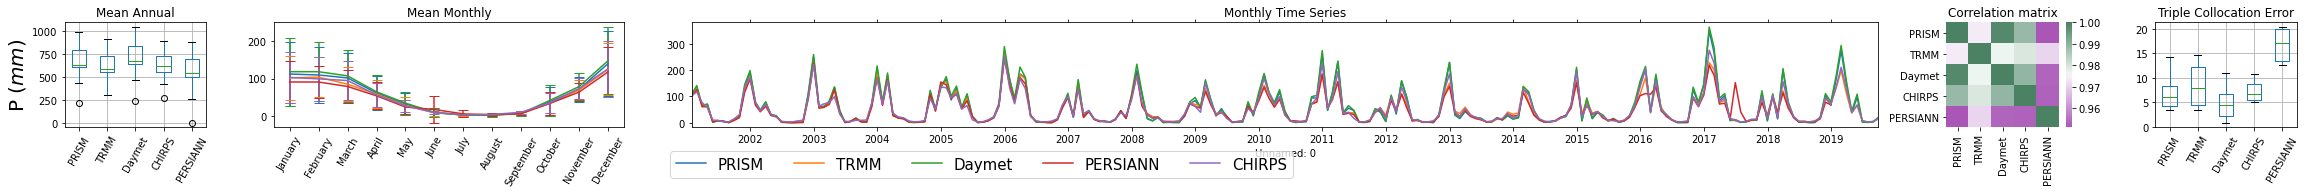

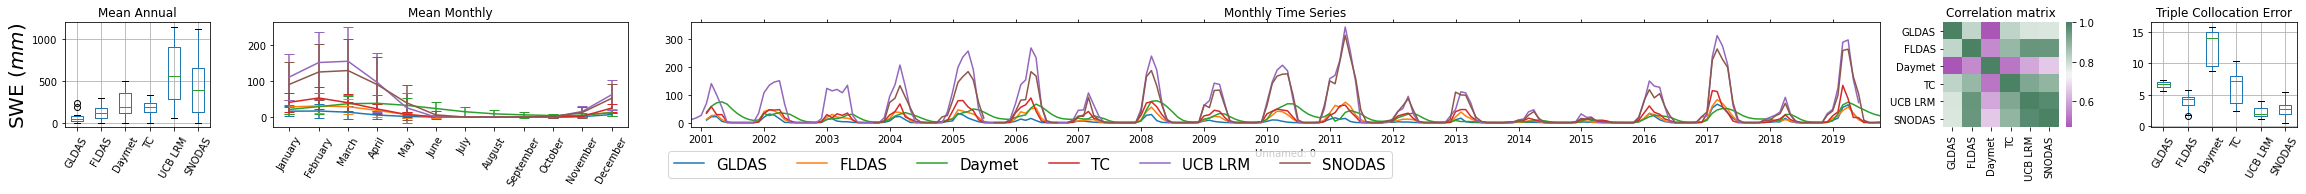

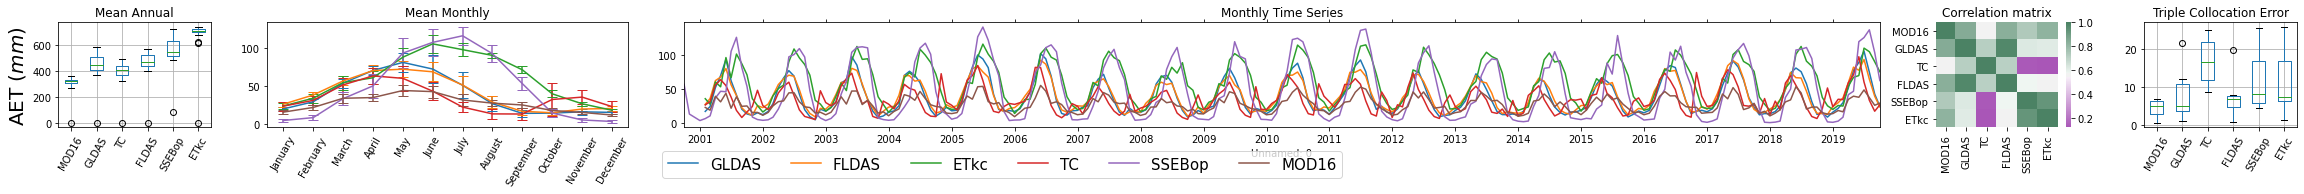

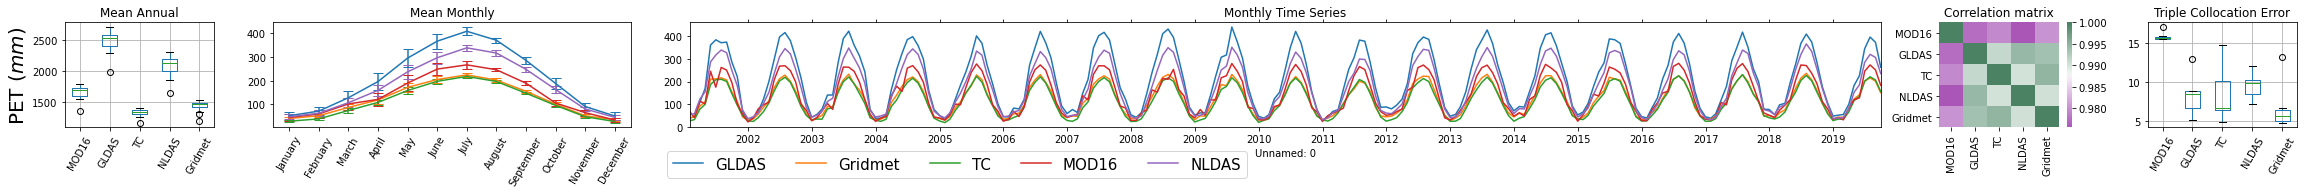

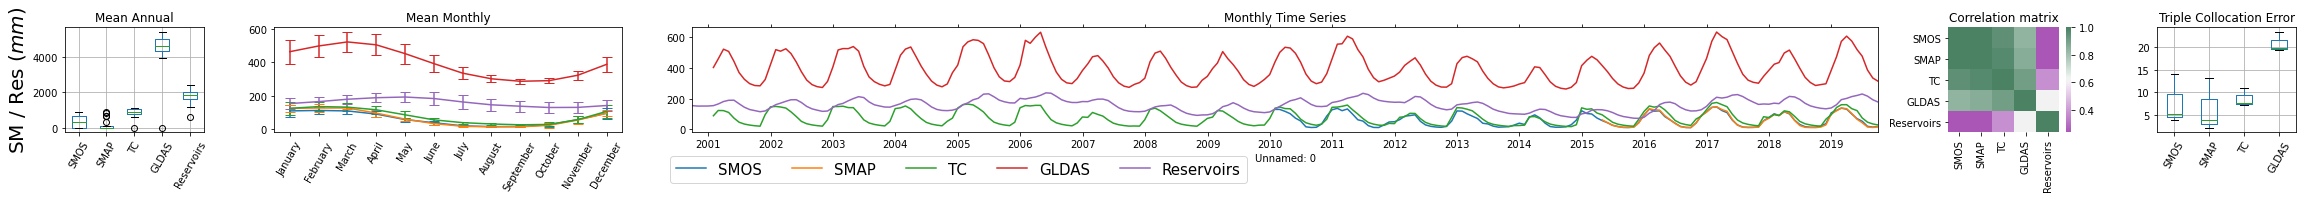

In [10]:
# CVWS Fig S1 

make_plots(pdf / 155000 * 1e6, pcoldict, var = "P")
make_plots(swedf / 155000 * 1e6, swecoldict, var = "SWE")
make_plots(aetdf / 155000 * 1e6, aetcoldict, var = "AET")
make_plots(petdf / 155000 * 1e6, petcoldict, var = "PET")
make_plots(smdf / 155000 * 1e6, smcoldict, var = "SM / Res")

In [11]:
# CVWS Balance

In [12]:
# CVWS ensemble list 
plist = ['PRISM','TRMM','PERSIANN','Daymet','CHIRPS']
swelist = ['UCB LRM','SNODAS', "TC","FLDAS"]
etlist = ['SSEBop','ETkc', "MOD16"]
smlist = ['SMOS','SMAP','TC']

combolist = list(itertools.product(*[plist,swelist,etlist,smlist]))
print("Ensemble has {} members".format(str(len(combolist))))

Ensemble has 180 members


In [13]:
# Run the ensemble 
dsens = []
for p,swe,et,sm in combolist:
    ds = pdf[p] - aetdf[et] - rdf['DWR Qout'] - swedf[swe].diff() - smdf['Reservoirs'].diff() - smdf[sm].diff() 
    dsens.append(np.cumsum(ds - np.mean(ds[:60])))

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-14-b9ade59a9e15>:10: RuntimeWarning: Mean of empty slice
  ax1.plot(dsens[0].index,np.nanmean(np.vstack(dsens)/ 155000 * 1e6, axis = 0), linewidth = 3, color = 'black')
/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-14-b9ade59a9e15>:24: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), alpha = 0)


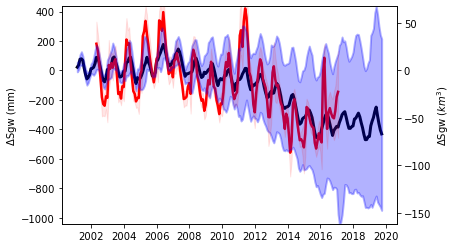

In [14]:
fig, ax1 = plt.subplots()

# plot all ensembles - make alpha >0 if desired 
for d in dsens:
    ax1.plot(d / 155000 * 1e6, alpha = 0.0, color = 'gray')

p25 = np.nanquantile(np.vstack(dsens)/ 155000 * 1e6,0.15, axis =0)
p75 = np.nanquantile(np.vstack(dsens)/ 155000 * 1e6,0.85, axis =0)
    
ax1.plot(dsens[0].index,np.nanmean(np.vstack(dsens)/ 155000 * 1e6, axis = 0), linewidth = 3, color = 'black')
ax1.plot(grace.index, grace['grace_mean']/ 155000 * 1e6, color="red", linewidth = 2.5,label = "NASA GRACE") 
ax1.set_ylabel('ΔSgw (mm)')
ax1.set_ylim([np.nanmin(p25),np.nanmax(p75)])

ax2 = ax1.twinx()  

# plot all ensembles - make alpha >0 if desired 
for d in dsens:
    ax2.plot(d, alpha = 0.0, color = 'gray')

# 75 th 25th quantile
p25 = np.nanquantile(np.vstack(dsens),0.15, axis =0)
p75 = np.nanquantile(np.vstack(dsens),0.85, axis =0)
ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), alpha = 0)
ax2.fill_between(dsens[0].index,p25,p75, linewidth =2, alpha = 0.3, color = 'blue')
ax2.plot(grace.index, grace['grace_mean'], color="red",alpha = 0, label = "NASA GRACE") 
ax2.fill_between(grace.index,grace['grace_min'],grace['grace_max'], alpha = 0.1, color = 'red')

ax2.tick_params(axis='y')
ax2.set_ylabel('ΔSgw ($km^3$)')
ax2.set_ylim([np.nanmin(p25),np.nanmax(p75)])

plt.show()

In [15]:
# Make nice fig 

# Record cvws ds for later 
cvws_ds = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
cvws_ds.columns = ['cvws_ds']

# Calc some discharge stats
p1 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 70)
p2 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 90)
p3 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 99)

# Calc some reservoir stats
rp1 = np.percentile(reservoirs['Smean'], 50)
rp2 = np.percentile(reservoirs['Smean'], 90)
rp3 = np.percentile(reservoirs['Smean'], 99)


<ipython-input-15-68a41bd74360>:4: RuntimeWarning: Mean of empty slice
  cvws_ds = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)


<ipython-input-16-840eb758975a>:63: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), color="black", linewidth = 2.5, label = "HyDRA CVWS $\Delta S_{gw}$ ensemble mean")
<ipython-input-16-840eb758975a>:74: RuntimeWarning: Mean of empty slice
  ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens) / 155000 * 1e6, axis = 0), alpha = 0)
<ipython-input-16-840eb758975a>:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


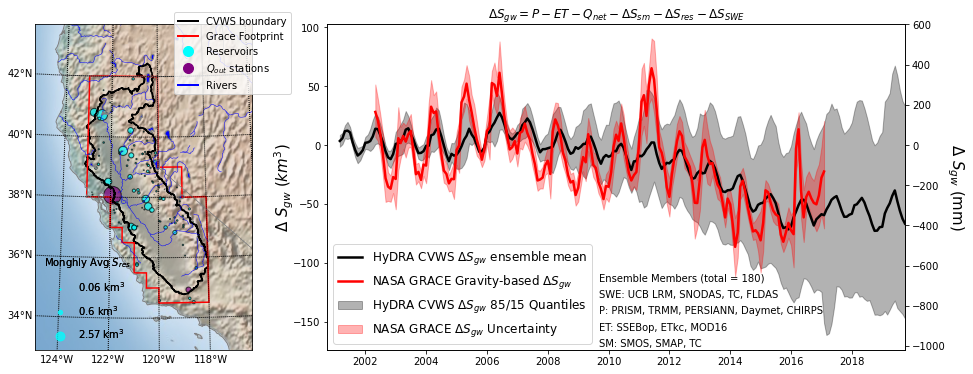

In [16]:
# Setup the figure
plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 3)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(outflow,m, alpha = 0.7, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*30,  color= 'cyan', edgecolor = 'black')


# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['CVWS boundary', 
                                 "Grace Footprint",
                                 "Reservoirs","$Q_{out}$ stations", "Rivers"], 
                    loc = "upper right",
                    prop={'size':10}, 
                    bbox_to_anchor=(1.2, 1.05))

# Make second legend for reservoir storage
for p in [rp1, rp2, rp3]:
    plt.scatter([], [], c='cyan', alpha=0.5, s=p*30,
                label=str(round(p,2)) + ' km$^3$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $S_{res}$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[0:2, 1:])
ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), color="black", linewidth = 2.5, label = "HyDRA CVWS $\Delta S_{gw}$ ensemble mean")
ax2.fill_between(dsens[0].index, p25,p75, color = 'black',  alpha = 0.3, label = "HyDRA CVWS $\Delta S_{gw}$ 85/15 Quantiles")
ax2.plot(grace.index, grace['grace_mean'], color="red", linewidth = 2.5, label = "NASA GRACE Gravity-based $\Delta S_{gw}$") 
ax2.fill_between(grace.index,grace['grace_min'],grace['grace_max'], alpha = 0.3, color = 'red', label = "NASA GRACE $\Delta S_{gw}$ Uncertainty")

ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res} - \Delta S_{SWE}$")
ax2.set_xlim(dsens[0].index[0],dsens[0].index[-1])
ax2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 15, labelpad= -3.) 
ax2.legend(loc = "lower left",  prop={'size':12})

ax3 = ax2.twinx()
ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens) / 155000 * 1e6, axis = 0), alpha = 0)
ax3.fill_between(dsens[0].index, p25 / 155000 * 1e6,p75 / 155000 * 1e6, alpha = 0)
ax3.plot(wbdf.index, wbdf['grace'] / 155000 * 1e6, alpha = 0) 

ax3.set_xlim(dsens[0].index[0],dsens[0].index[-1])
ax3.set_ylabel('$\Delta$ $S_{gw}$ (mm)', size = 15, labelpad= 20., rotation = 270) 


ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist))), xy=(0.47, 0.21), xycoords='axes fraction')
ax3.annotate("P: " + ", ".join(plist), xy=(0.47,0.11), xycoords='axes fraction')
ax3.annotate("SWE: " + ", ".join(swelist), xy=(0.47,0.16), xycoords='axes fraction')
ax3.annotate("ET: " + ", ".join(etlist), xy=(0.47, 0.06), xycoords='axes fraction')
ax3.annotate("SM: " + ", ".join(smlist), xy=(0.47, 0.01), xycoords='axes fraction')

G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

align_yaxis(ax2, 0, ax3, 0)

plt.tight_layout()
plt.show()

# CV

In [17]:
pcoldict = {'p_prism':'PRISM', 
                'p_trmm':'TRMM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())][323:-12]
pdf.dropna(axis = 0, how = 'all', inplace = True)
pdf.rename(columns = pcoldict, inplace = True)

aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'ETkc':"ETkc",
                'aet_tc':'TC',
                'ssebop_cv': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())][323:-12]
aetdf.dropna(axis = 0, how = 'all', inplace = True)
aetdf.rename(columns = aetcoldict, inplace = True)

petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TC',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())][323:-12]
petdf.dropna(axis = 0, how = 'all', inplace = True)
petdf.rename(columns = petcoldict, inplace = True)


smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TC',
                'sm_gldas': "GLDAS",
                'Sres_cv':"Reservoirs"}
smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())][323:-12]
smdf.dropna(axis = 0, how = 'all', inplace = True)
smdf.rename(columns = smcoldict, inplace = True)

rcoldict = {'qs_out_km3':'DWR Qout', 
            'qs_in_km3': 'USGS Qin',
            'r_fldas_cv':'FLDAS',  
            'r_tc_cv':'TC',
            'r_gldas_cv': "GLDAS"}
rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())][323:-12]
rdf.dropna(axis = 0, how = 'all', inplace = True)
rdf.rename(columns = rcoldict, inplace = True)

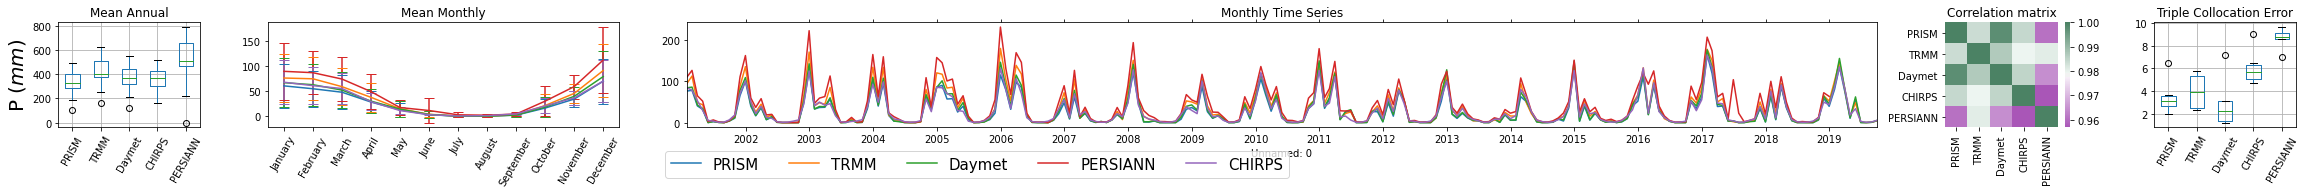

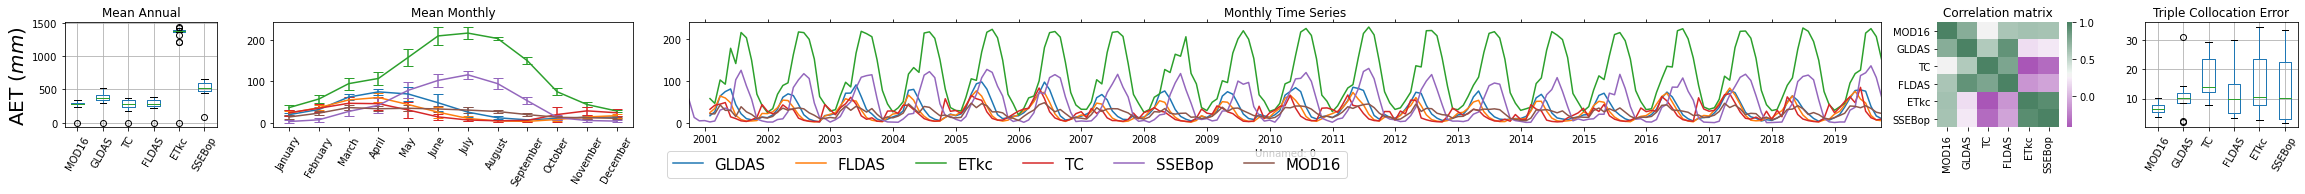

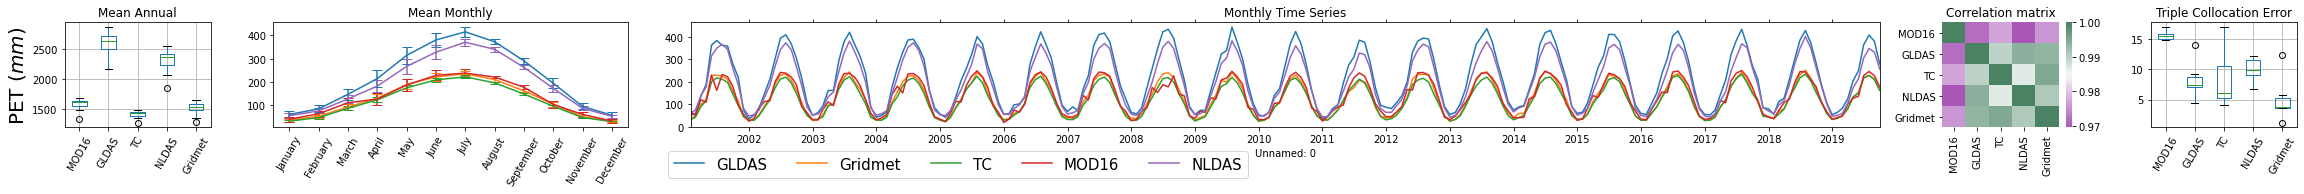

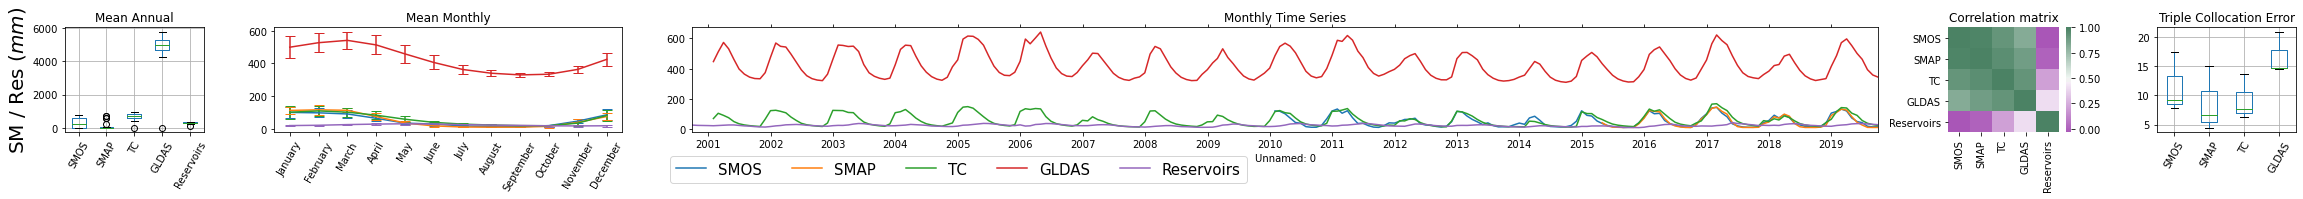

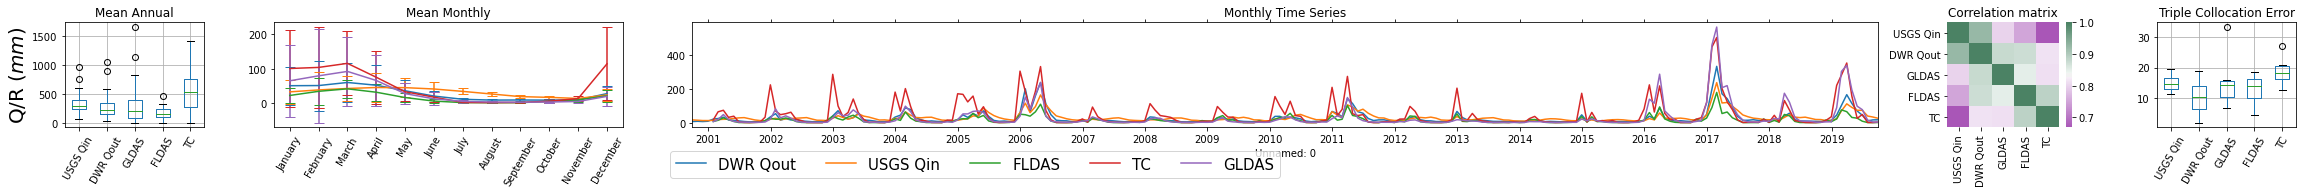

In [18]:
make_plots(pdf/ 55000 * 1e6, pcoldict, var = "P")
make_plots(aetdf/ 55000 * 1e6, aetcoldict, var = "AET")
make_plots(petdf/ 55000 * 1e6, petcoldict, var = "PET")
make_plots(smdf/ 55000 * 1e6, smcoldict, var = "SM / Res")
make_plots(rdf/ 55000 * 1e6, rcoldict, var = "Q/R")

In [19]:
# CV ensemble list 
plist = ['PRISM','TRMM','PERSIANN','Daymet','CHIRPS']
etlist = ['SSEBop','ETkc',"MOD16"]
smlist = ['SMOS','SMAP','TC']
rlist = ['FLDAS', 'TC']

combolist = list(itertools.product(*[plist,etlist,smlist,rlist]))
print("Ensemble has {} members".format(str(len(combolist))))

Ensemble has 90 members


In [20]:
dsens = []
for p,et,sm,r in combolist:
    ds = pdf[p] - aetdf[et] - rdf['DWR Qout'] + rdf['USGS Qin'] - smdf['Reservoirs'].diff() - smdf[sm].diff() + rdf[r]
    dsens.append(np.cumsum(ds - np.mean(ds[:60])))

<ipython-input-21-24646f369211>:2: RuntimeWarning: Mean of empty slice
  cv_ds = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-21-24646f369211>:14: RuntimeWarning: Mean of empty slice
  ax1.plot(dsens[0].index,np.nanmean(np.vstack(dsens)/ 55000 * 1e6, axis = 0), linewidth = 3, color = 'black')
/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-21-24646f369211>:30: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), alpha = 0)


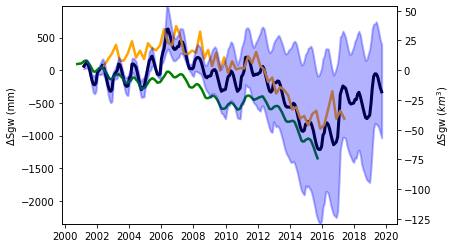

In [21]:
# record the ds for later 
cv_ds = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
cv_ds.columns = ['cv_ds']

fig, ax1 = plt.subplots()

# Uncomment to plot all ensembles
for d in dsens:
    ax1.plot(d / 155000 * 1e6, alpha = 0.001, color = 'gray')

p25 = np.nanquantile(np.vstack(dsens)/ 55000 * 1e6,0.15, axis =0)
p75 = np.nanquantile(np.vstack(dsens)/ 55000 * 1e6,0.85, axis =0)
    
ax1.plot(dsens[0].index,np.nanmean(np.vstack(dsens)/ 55000 * 1e6, axis = 0), linewidth = 3, color = 'black')
ax1.plot(wells.index, wells['wells_ds_km3']/ 55000 * 1e6, color="orange", linewidth = 2.5,label = "Wells") 
ax1.plot(wbdf['c2vsim_ds'][323:].index, wbdf['c2vsim_ds'][323:]/ 55000 * 1e6, color="green", linewidth = 2.5,label = "C2vsim") 

ax1.set_ylabel('ΔSgw (mm)')
ax1.set_ylim([np.nanmin(p25),np.nanmax(p75)])

ax2 = ax1.twinx()  

# Uncomment to plot all ensembles
for d in dsens:
    ax2.plot(d, alpha = 0.0, color = 'gray')

# 75 th 25th quantile
p25 = np.nanquantile(np.vstack(dsens),0.15, axis =0)
p75 = np.nanquantile(np.vstack(dsens),0.85, axis =0)
ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), alpha = 0)
ax2.fill_between(dsens[0].index,p25,p75, linewidth =2, alpha = 0.3, color = 'blue')
ax2.plot(wbdf.index, wbdf['wells_ds_km3'], color="orange",alpha = 0, label = "Wells") 
# ax2.plot(wbdf.index, wbdf['c2vsim_ds'][327:], color="green",alpha = 0, label = "C2vsim") 

ax2.tick_params(axis='y')
ax2.set_ylabel('ΔSgw ($km^3$)')
ax2.set_ylim([np.nanmin(p25),np.nanmax(p75)])

plt.show()

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-22-a2044a17e061>:66: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), color="black", linewidth = 2.5, label = "HyDRA CVWS $\Delta S_{gw}$ ensemble mean")
/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-22-a2044a17e061>:79: RuntimeWarning: Mean of empty slice
  ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens) / 155000 * 1e6, axis = 0), alpha = 0)
<ipython-input-22-a2044a17e061>:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


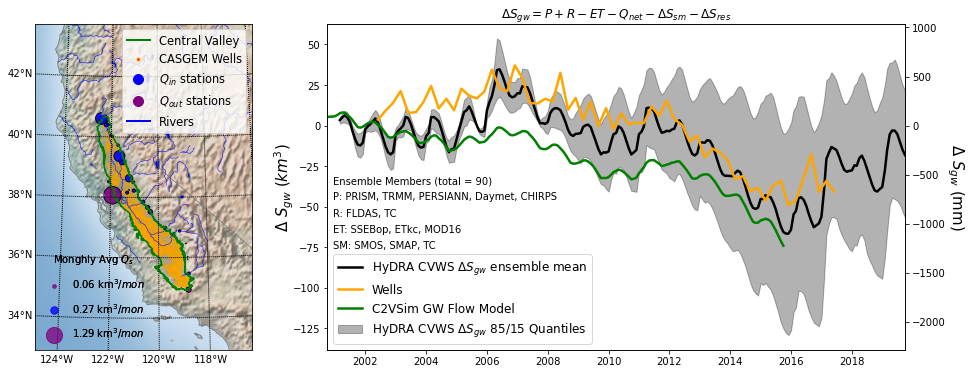

In [22]:
# Setup the figure
plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 3)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'orange', fill = True)
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'orange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'blue',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['Central Valley', 
                                 'CASGEM Wells', 
                                 "$Q_{in}$ stations","$Q_{out}$ stations",  
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':11.5})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    plt.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $Q_s$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[0:2, 1:])
p25 = np.nanquantile(np.vstack(dsens),0.15, axis =0)
p75 = np.nanquantile(np.vstack(dsens),0.85, axis =0)
ax3.set_ylim([np.nanmin(p25),np.nanmax(p75)])

ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0), color="black", linewidth = 2.5, label = "HyDRA CVWS $\Delta S_{gw}$ ensemble mean")
ax2.fill_between(dsens[0].index, p25,p75, color = 'black', alpha = 0.3, label = "HyDRA CVWS $\Delta S_{gw}$ 85/15 Quantiles")
ax2.plot(wells.index, wells['wells_ds_km3'], color="orange", linewidth = 2.5,label = "Wells") 
ax2.plot(wbdf['c2vsim_ds'][323:].index, wbdf['c2vsim_ds'][323:], color="green", linewidth = 2.5,label = "C2VSim GW Flow Model") 

ax2.set_title("$\Delta S_{gw} = P + R - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res}$")
ax2.set_xlim(dsens[0].index[0],dsens[0].index[-1])
ax2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 15, labelpad= -3.) 
ax2.legend(loc = "lower left",  prop={'size':12})

ax3 = ax2.twinx()
p25 = np.nanquantile(np.vstack(dsens)/ 55000 * 1e6,0.15, axis =0)
p75 = np.nanquantile(np.vstack(dsens)/ 55000 * 1e6,0.85, axis =0)
ax3.plot(dsens[0].index,np.nanmean(np.vstack(dsens) / 155000 * 1e6, axis = 0), alpha = 0)
ax3.fill_between(dsens[0].index, p25,p75, alpha = 0)

ax3.set_xlim(dsens[0].index[0],dsens[0].index[-1])
ax3.set_ylabel('$\Delta$ $S_{gw}$ (mm)', size = 15, labelpad= 20, rotation = 270) 
ax3.set_ylim([np.nanmin(p25),np.nanmax(p75)])

ax3.annotate("Ensemble Members (total = {})".format(str(len(combolist))), xy=(0.01, 0.51), xycoords='axes fraction')
ax3.annotate("P: " + ", ".join(plist), xy=(0.01,0.46), xycoords='axes fraction')
ax3.annotate("R: " + ", ".join(rlist), xy=(0.01,0.41), xycoords='axes fraction')
ax3.annotate("ET: " + ", ".join(etlist), xy=(0.01, 0.36), xycoords='axes fraction')
ax3.annotate("SM: " + ", ".join(smlist), xy=(0.01, 0.31), xycoords='axes fraction')

G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

align_yaxis(ax2, 0, ax3, 0)
plt.tight_layout()
plt.show()

In [23]:
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cv_ds'][df_mask].values
    rscvws = df['cvws_ds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],2) for k,v in d.items()}
    
    return polyfits

In [24]:
grace_rs = pd.merge(grace,cv_ds, left_index = True, right_index = True)
grace_rs2 = pd.merge(grace_rs,cvws_ds, left_index = True, right_index = True)
grs_c2v = pd.merge(grace_rs2, wbdf['c2vsim_ds'],left_index = True, right_index = True)
fin_dsdf = pd.merge(grs_c2v, wells,left_index = True, right_index = True, how = 'outer')

In [25]:
fin_dsdf.drop(['grace_min','grace_max'], axis = 1, inplace = True)

In [26]:

d1s,d1e = '2006-10-01', '2009-09-30'
d1t = get_trendlines(d1s,d1e,fin_dsdf)
d1s = get_slopes(d1s,d1e,fin_dsdf)

d2s,d2e = '2011-10-01', '2015-09-30'
d2t = get_trendlines(d2s,d2e,fin_dsdf)
d2s = get_slopes(d2s,d2e,fin_dsdf)

rc1s,rc1e = '2005-10-01', '2006-09-30'
rc1 = get_trendlines(rc1s,rc1e,fin_dsdf)
rc1s = get_slopes(rc1s,rc1e,fin_dsdf)

rc2s,rc2e = '2009-10-01', '2011-09-30'
rc2 = get_trendlines(rc2s,rc2e,fin_dsdf)
rc2s = get_slopes(rc2s,rc2e,fin_dsdf)

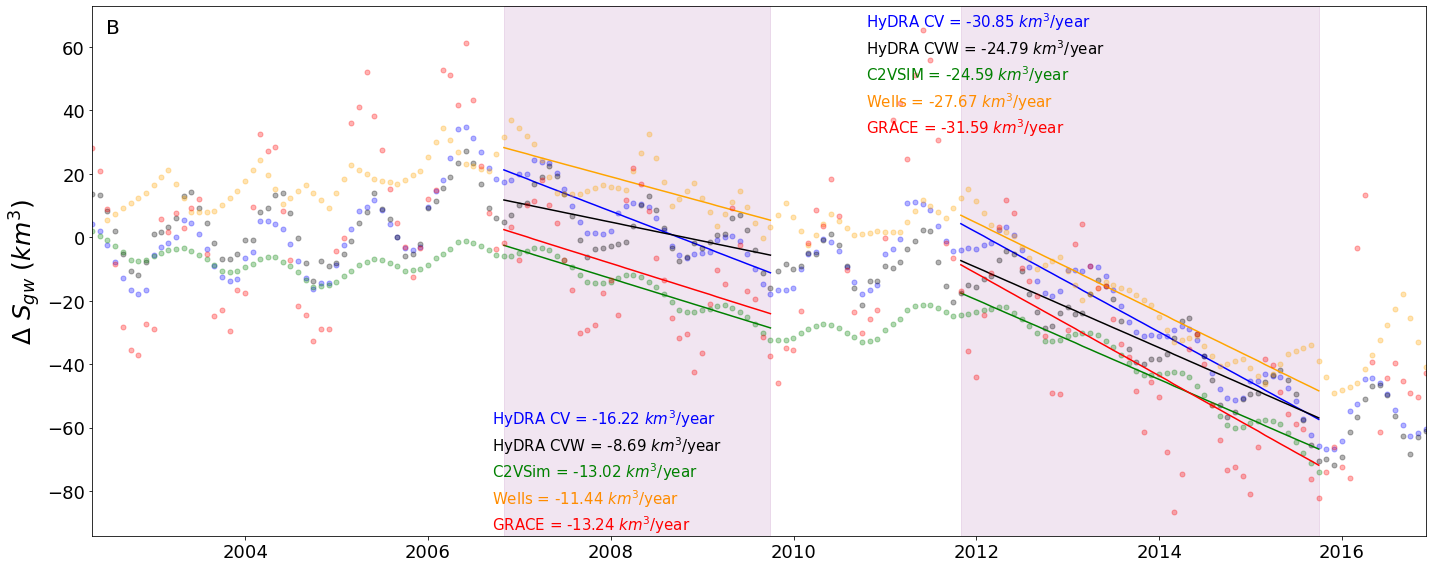

In [27]:
plt.figure(figsize = (20,8))
axes_2 = plt.subplot(111)

axes_2.plot(fin_dsdf.index,fin_dsdf['cv_ds'], 'o', color = 'blue', ms=5, alpha = 0.3, label = "HyDRA CV")
# axes_2.fill_between(fin_dsdf.index,fin_dsdf['cvds'] - mean_errs['HyDRA'], fin_dsdf['cvds'] + mean_errs['HyDRA'], 
#                     color = 'blue', alpha = 0.3, label = "HyDRA CV Uncertainty")
axes_2.plot(d1t['HyDRAcv'], color = 'blue') # trendline 
axes_2.plot(d2t['HyDRAcv'], color = 'blue') # trendline 


# CVWS
axes_2.plot(fin_dsdf.index,fin_dsdf['cvws_ds'], 'o', color = 'black', ms=5, alpha = 0.3, label = "HyDRA CVWS")
# axes_2.fill_between(fin_dsdf.index,fin_dsdf['cvwds'] - mean_errs['HyDRA'], fin_dsdf['cvwds'] + mean_errs['HyDRA'],
#                     color = 'black', alpha = 0.3, label = "HyDRA CVWS Uncertainty")
axes_2.plot(d1t['HyDRAcvws'], color = 'black') # trendline 
axes_2.plot(d2t['HyDRAcvws'], color = 'black') # trendline 


# C2VSIm
axes_2.plot(fin_dsdf.index,fin_dsdf['c2vsim_ds'], 'o', color = 'green', ms=5, alpha = 0.3, label = "C2VSim")
# axes_2.fill_between(fin_dsdf.index,fin_dsdf['c2vsim_ds'] - mean_errs['C2VSim'], fin_dsdf['c2vsim_ds'] + mean_errs['C2VSim'],
#                     color = 'green', alpha = 0.3, label = "C2VSim Uncertainty")
axes_2.plot(d1t['C2VSim'], color = 'green') # trendline 
axes_2.plot(d2t['C2VSim'], color = 'green') # trendline 


# Wells
winterp = fin_dsdf['wells_ds_km3'].interpolate(how = 'linear')
well_mask = (winterp.index > fin_dsdf['wells_ds_km3'].dropna().index[0]) & (winterp.index <= fin_dsdf['wells_ds_km3'].dropna().index[-1])
winterp = winterp[well_mask]
axes_2.plot(winterp.index,winterp, 'o', color = 'orange', ms=5, alpha = 0.3, label = "Wells")
# plt.fill_between(winterp.index, winterp - mean_errs['Wells'], winterp+ mean_errs['Wells'],
#                     color = 'orange', alpha = 0.3, label = "Wells Uncertainty")
axes_2.plot(d1t['Wells'], color = 'orange') # trendline 
axes_2.plot(d2t['Wells'], color = 'orange') # trendline 


# GRACE
axes_2.plot(fin_dsdf.index,fin_dsdf['grace_mean'], 'o', color = 'red', ms=5, alpha = 0.3, label = "GRACE")
# axes_2.fill_between(fin_dsdf.index,fin_dsdf['grace'] - mean_errs['GRACE'], fin_dsdf['grace'] + mean_errs['GRACE'],
#                     color = 'red', alpha = 0.3, label = "GRACE Uncertainty")
axes_2.plot(d1t['GRACE'], color = 'red') # trendline 
axes_2.plot(d2t['GRACE'], color = 'red') # trendline 

# X limits 
axes_2.set_xlim(fin_dsdf.index[0],fin_dsdf.index[-5])
axes_2.annotate("B", xy=(0.01, 0.95), xycoords="axes fraction", size = 20)

# Labels and legend 
axes_2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_2.tick_params(axis='both', which='major', labelsize=18)

axes_2.annotate("HyDRA CV = {} $km^3$/year".format(d1s['HyDRAcv']),xy=(0.30, 0.21), color = 'blue', xycoords="axes fraction", size = 15)
axes_2.annotate("HyDRA CVW = {} $km^3$/year".format(d1s['HyDRAcvws']),xy=(0.30, 0.16),color = "black", xycoords="axes fraction", size = 15)
axes_2.annotate("C2VSim = {} $km^3$/year".format(d1s['C2VSim']),xy=(0.30, 0.11), color = 'green', xycoords="axes fraction", size = 15)
axes_2.annotate("Wells = {} $km^3$/year".format(d1s['Wells']),xy=(0.30, 0.06), color = 'darkorange', xycoords="axes fraction", size = 15)
axes_2.annotate("GRACE = {} $km^3$/year".format(d1s['GRACE']),xy=(0.30, 0.01), color = 'red',xycoords="axes fraction", size = 15)

axes_2.axvspan(d1t['GRACE'].index[0], d1t['GRACE'].index[-1], alpha=0.051, color='purple')
axes_2.axvspan(d1t['GRACE'].index[0], d1t['GRACE'].index[-1], alpha=0.051, color='purple')

axes_2.annotate("HyDRA CV = {} $km^3$/year".format(d2s['HyDRAcv']),xy=(0.58, 0.96),color = 'blue', xycoords="axes fraction", size = 15)
axes_2.annotate("HyDRA CVW = {} $km^3$/year".format(d2s['HyDRAcvws']),xy=(0.58, 0.91),color = "black", xycoords="axes fraction", size = 15)
axes_2.annotate("C2VSIM = {} $km^3$/year".format(d2s['C2VSim']),xy=(0.58, 0.86), color = 'green', xycoords="axes fraction", size = 15)
axes_2.annotate("Wells = {} $km^3$/year".format(d2s['Wells']),xy=(0.58, 0.81), color = 'darkorange', xycoords="axes fraction", size = 15)
axes_2.annotate("GRACE = {} $km^3$/year".format(d2s['GRACE']),xy=(0.58, 0.76), color = 'red',xycoords="axes fraction", size = 15)


axes_2.axvspan(d2t['GRACE'].index[0], d2t['GRACE'].index[-1], alpha=0.051, color='purple')
axes_2.axvspan(d2t['GRACE'].index[0], d2t['GRACE'].index[-1], alpha=0.051, color='purple')

plt.tight_layout()

# Do ensemble Balances

In [ ]:
# CV
plist = [pdf['PRISM'], pdf['TRMM'], pdf['PERSIANN']]
etlist = [etdf['SSEBop'],etdf['ETkc']]
rlist = [rdf['FLDAS'],rdf['TC']]
qout = rdf['DWR Qout']
qin = rdf['USGS Qin']


In [ ]:
# CVWS
plist = [pdf['PRISM'], pdf['TRMM'], pdf['PERSIANN']]
swelist = [swedf['SNODAS'],swedf['Daymet'],swedf['UCB LRM']]
etlist = [etdf['SSEBop'],etdf['ETkc']]


In [ ]:
# CV
plist = [pdf['PRISM'], pdf['TRMM'], pdf['PERSIANN']]
etlist = [etdf['SSEBop'],etdf['ETkc']]
rlist = [rdf['FLDAS'],rdf['TC']]
qout = rdf['DWR Qout']
qin = rdf['USGS Qin']


In [ ]:


def do_tc(df):
    tc_dict = df.astype(float).to_dict('list')

    combos=combinations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

In [ ]:
def make_plots(df):
    
    plt.figure(figsize=(35,3))
    G = gridspec.GridSpec(9, 12)

    ax1 = plt.subplot(G[:, 0])

    # Boxplot
    df.resample("Y").mean().boxplot(ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60)
    ax1.set_title("Mean Annual")
    ax1.set_ylabel("SWE $(km^3)$")

    # Monthly mean plot with errs
    ax2 = plt.subplot(G[:,1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()

    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B') for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)# ,labels = labels, rotation = 60)
    ax2.set_xticklabels(labels,rotation = 60)
    ax2.set_title("Mean Monthly")

    ax3 = plt.subplot(G[:,3:-3])
    df.plot(ax = ax3,x_compat=True,color = [cc[1] for cc in zip(swecols,colors)])
    ax3.xaxis.set_tick_params(reset=True)
    ax3.xaxis.set_major_locator(mdates.YearLocator(1))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.set_xlim([df.index[0],df.index[-1]])
    ax3.set_title("Monthly Time Series")
    # Legend in the center 
    leg = ax3.legend(loc='lower center', ncol = len(colors), bbox_to_anchor=(0.5, -0.45),
               fancybox=True,  prop={'size': 12})

    ax4 = plt.subplot(G[:,-3:-2])
    sns.heatmap(df.corr(), ax = ax4, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax4.set_title("Correlation matrix")


    ax5 = plt.subplot(G[:,-2:-1])
    pd.DataFrame.from_dict(do_tc(df.dropna())).boxplot(ax = ax5)
    ax5.set_xticklabels(ax1.get_xticklabels(),rotation = 60)
    ax5.set_title("Triple Collocation Error")

    plt.tight_layout()
    plt.show()

In [ ]:
colors = sns.color_palette()
swecoldict = {'swe_gldas_cvws':'GLDAS', 
                'swe_fldas_cvws':'FLDAS',  
                'swe_dmet_cvws':"Daymet",
                'swe_tc_cvws':'TC',
                'swe_lrm': "UCB LRM",
                'swe_snodas': "SNODAS"}

cdict = dict(zip(list(swecoldict.values()),colors))
swedf = wbdf.loc[:, wbdf.columns.isin(swecoldict.keys())][323:-12]
swedf.rename(columns = swecoldict, inplace = True)

In [ ]:
make_plots(swedf)

In [ ]:
# Final plotting template

colors = sns.color_palette()
swecoldict = {'swe_gldas_cvws':'GLDAS', 
                'swe_fldas_cvws':'FLDAS',  
                'swe_dmet_cvws':"Daymet",
                'swe_tc_cvws':'TC',
                'swe_lrm': "UCB LRM",
                'swe_snodas': "SNODAS"}

cdict = dict(zip(list(swecoldict.values()),colors))
swedf = wbdf.loc[:, wbdf.columns.isin(swecoldict.keys())][323:-12]
swedf.rename(columns = swecoldict, inplace = True)

plt.figure(figsize=(35,3))
G = gridspec.GridSpec(9, 12)

ax1 = plt.subplot(G[:, 0])

# Boxplot
swedf.resample("Y").mean().boxplot(ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60)
ax1.set_title("Mean Annual")
ax1.set_ylabel("SWE $(km^3)$")

# Monthly mean plot with errs
ax2 = plt.subplot(G[:,1:3])
monthly = swedf.groupby(swedf.index.month).mean()
errs= swedf.groupby(swedf.index.month).std()

for k,v in cdict.items():
    ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

labels = [datetime.date(1900, x, 1).strftime('%B') for x in swedf.groupby(swedf.index.month).mean().index]
ax2.set_xticks(ticks = swedf.groupby(swedf.index.month).mean().index)# ,labels = labels, rotation = 60)
ax2.set_xticklabels(labels,rotation = 60)
ax2.set_title("Mean Monthly")

ax3 = plt.subplot(G[:,3:-3])
swedf.plot(ax = ax3,x_compat=True,color = [cc[1] for cc in zip(swecols,colors)])
ax3.xaxis.set_tick_params(reset=True)
ax3.xaxis.set_major_locator(mdates.YearLocator(1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax3.set_xlim([swedf.index[0],swedf.index[-1]])
ax3.set_title("Monthly Time Series")
# Legend in the center 
leg = ax3.legend(loc='lower center', ncol = len(colors), bbox_to_anchor=(0.5, -0.45),
           fancybox=True,  prop={'size': 12})

ax4 = plt.subplot(G[:,-3:-2])
sns.heatmap(swedf.corr(), ax = ax4, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
ax4.set_title("Correlation matrix")


ax5 = plt.subplot(G[:,-2:-1])
pd.DataFrame.from_dict(do_tc(swedf.dropna())).boxplot(ax = ax5)
ax5.set_xticklabels(ax1.get_xticklabels(),rotation = 60)
ax5.set_title("Triple Collocation Error")

plt.tight_layout()
plt.show()

In [ ]:
swedf.resample("Y").mean().boxplot(color = colors)




In [ ]:
pcols = ['p_prism', 'p_dmet', 'p_trmm', 'p_psn','p_chirps']
pdf = wbdf.loc[:, wbdf.columns.isin(pcols)]
pdf.rename(columns = {'p_prism':'PRISM', 
                'p_trmm':'TRMM',  
                'p_dmet':"Daymet",
                'p_chirps':'CHIRPS',
                'p_psn': "PERSIANN"}, inplace = True)
pdf.resample("Y").mean().boxplot()
pdf.groupby(pdf.index.month).mean().plot(yerr = pdf.groupby(pdf.index.month).std())

plt.ylabel('P ($km^3$)')
plt.ylim([0,10])

In [ ]:
aetcols = ['aet_modis', 'aet_gldas', 'aet_fldas', 'ssebop_cv','ETkc']
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcols)]
aetdf.rename(columns = {'aet_modis':'MOD16', 
                'aet_gldas':'GLDAS',  
                'aet_fldas':"FLDAS",
                'ssebop_cv':'SSEBop',
                'ETkc': "ETcv"}, inplace = True)
aetdf.resample("Y").mean().boxplot()
aetdf.groupby(petdf.index.month).mean().plot(yerr = aetdf.groupby(aetdf.index.month).std())
plt.ylabel('AET ($km^3$)')
plt.ylim([0,14])

In [ ]:
petcols = ['pet_modis', 'pet_gldas', 'pet_nldas', 'pet_tc', 'pet_gmet']
petdf = wbdf.loc[:, wbdf.columns.isin(petcols)]
petdf.rename(columns = {'pet_modis':'MOD16', 
                'pet_gldas':'GLDAS',  
                'pet_nldas':"NLDAS",
                'pet_gmet':"Gridmet",
                'pet_tc':"Terraclimate",
                }, inplace = True)
petdf.resample("Y").mean().boxplot()
petdf.groupby(petdf.index.month).mean().plot(yerr = petdf.groupby(petdf.index.month).std())
plt.ylabel('pet ($km^3$)')


In [ ]:
petdf

In [ ]:

smcols = ['sm_smos', 'sm_smap', 'sm_tc', 'sm_gldas']
smdf = wbdf.loc[:, wbdf.columns.isin(smcols)]
smdf.rename(columns = {'sm_smos':'SMOS', 
                'sm_gldas':'GLDAS',  
                'sm_smap':"SMAP",
                'sm_tc':"Terraclimate",
                }, inplace = True)
smdf.resample("Y").mean().boxplot()
smdf.groupby(smdf.index.month).mean().plot(yerr = smdf.groupby(smdf.index.month).std())
plt.ylabel('sm ($km^3$)')


In [ ]:

rcols = ['r_tc', 'r_gldas', 'r_fldas','qs_in_km3', 'qs_out_km3']
rdf = wbdf.loc[:, wbdf.columns.isin(rcols)]
rdf.rename(columns = {'r_fldas':'FLDAS', 
                'r_gldas':'GLDAS',  
                'qs_in_km3':"USGS Inflow",
                'qs_out_km3':"DWR Outflow",
                'r_tc':"Terraclimate",
                }, inplace = True)
rdf.resample("Y").mean().boxplot()
rdf.groupby(rdf.index.month).mean().plot(yerr = rdf.groupby(rdf.index.month).std())
plt.ylabel('Q/R ($km^3$)')


# Make fig S1

In [ ]:
# Setup fig 

plotdf = wbdf[326:]

cols = ['Central Valley (55,000 $km^2$)', 'Central Valley Watershed (160,000 $km^2$)']
rows = ['P ($km^3$)', 'AET ($km^3$)', 'PET ($km^3$)', 'Q / R ($km^3$)', " $\Delta$S ($km^3$)" ]

nrows = len(rows)
ncols = len(cols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))

########################################################################
######################## PRECIP ########################################
########################################################################

# PRECIP CV
ax1 = plt.subplot(nrows, ncols, 1)
ax1.set_title(cols[0], size = 20)
ax1.plot(plotdf['p_prism'], label = "PRISM", linewidth = 1.1)
ax1.plot(plotdf['p_trmm'], label = "TRMM", linewidth = 1.1)
ax1.plot(plotdf['p_chirps'], label = "CHIRPS", linewidth = 1.1)
ax1.plot(plotdf['p_dmet'], label = "Daymet", linewidth = 1.1)
ax1.plot(plotdf['p_psn'], label = "PERSIANN", linewidth = 1.1)


# Legend in the center 
leg = ax1.legend(loc='upper right', bbox_to_anchor=(1.205, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax1.set_ylabel(rows[0], size = 15)

# PRECIP CVWS
ax2 = plt.subplot(nrows, ncols, 2)
ax2.set_title(cols[1], size = 20)
ax2.plot(plotdf['p_prism_cvws'], label = "PRISM", linewidth = 1.1)
ax2.plot(plotdf['p_trmm_cvws'], label = "TRMM", linewidth = 1.1)
ax2.plot(plotdf['p_chirps_cvws'], label = "CHIRPS", linewidth = 1.1)
ax2.plot(plotdf['p_dmet_cvws'], label = "Daymet", linewidth = 1.1)
ax2.plot(plotdf['p_psn_cvws'], label = "PERSIANN", linewidth = 1.1)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(rows[0], size = 15)

########################################################################
######################## AET ###########################################
########################################################################

# AET CV
ax3 = plt.subplot(nrows, ncols, 3)
ax3.plot(plotdf['aet_modis'], label = "MOD16 AET", linewidth = 1.1)
ax3.plot(plotdf['ssebop_cv'], label = "SSEBop", linewidth = 1.1)
ax3.plot(plotdf['aet_gldas'], label = "GLDAS", linewidth = 1.1)
ax3.plot(plotdf['aet_fldas'], label = "FLDAS", linewidth = 1.1)
ax3.plot(plotdf['aet_tc'], label = "Terraclimate", linewidth = 1.1)
ax3.plot(plotdf['ETkc'], label = "ETcv", linewidth = 1.1)

# Legend in the center 
leg = ax3.legend(loc='upper right', bbox_to_anchor=(1.22, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax3.set_ylabel(rows[1], size = 15)

# AET CVWS
ax4 = plt.subplot(nrows, ncols, 4)
ax4.plot(plotdf['aet_modis_cvws'], label = "MOD16 AET", linewidth = 1.1)
ax4.plot(plotdf['ssebop_cvws'], label = "SSEBop", linewidth = 1.1)
ax4.plot(plotdf['aet_gldas_cvws'], label = "GLDAS", linewidth = 1.1)
ax4.plot(plotdf['aet_fldas_cvws'], label = "FLDAS", linewidth = 1.1)
ax4.plot(plotdf['aet_tc_cvws'], label = "Terraclimate", linewidth = 1.1)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel(rows[1], size = 15)

########################################################################
######################## PET ###########################################
########################################################################

# PET CV
ax5 = plt.subplot(nrows, ncols, 5)
ax5.plot(plotdf['pet_modis'], label = "MOD16 PET", linewidth = 1.1)
ax5.plot(plotdf['pet_gmet'], label = "Gridmet", linewidth = 1.1)
ax5.plot(plotdf['pet_gldas'], label = "GLDAS", linewidth = 1.1)
ax5.plot(plotdf['pet_nldas'], label = "NLDAS", linewidth = 1.1)
ax5.plot(plotdf['pet_tc'], label = "Terraclimate", linewidth = 1.1)

# Legend in the center 
leg = ax5.legend(loc='upper right', bbox_to_anchor=(1.22, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax5.set_ylabel(rows[2], size = 15)

# PET CVWS
ax6 = plt.subplot(nrows, ncols, 6)
ax6.plot(plotdf['pet_modis_cvws'], label = "MOD16 PET", linewidth = 1.1)
ax6.plot(plotdf['pet_gmet_cvws'], label = "Gridmet", linewidth = 1.1)
ax6.plot(plotdf['pet_gldas_cvws'], label = "GLDAS", linewidth = 1.1)
ax6.plot(plotdf['pet_nldas_cvws'], label = "NLDAS", linewidth = 1.1)
ax6.plot(plotdf['pet_tc_cvws'], label = "Terraclimate", linewidth = 1.1)

ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.set_ylabel(rows[2], size = 15)

########################################################################
######################## Q/R ###########################################
########################################################################

# Q/R CV
ax7 = plt.subplot(nrows, ncols, 7)
ax7.plot(plotdf['qs_out_km3'], label = "Outflow", linewidth = 1.1)
ax7.plot(plotdf['r_gldas'], label = "GLDAS", linewidth = 1.1)
ax7.plot(plotdf['r_fldas'], label = "FLDAS", linewidth = 1.1)
ax7.plot(plotdf['r_tc'], label = "Terraclimate", linewidth = 1.1)
ax7.plot(plotdf['qs_in_km3'], label = "CV Inflow", linewidth = 1.1)

# Legend in the center 
leg = ax7.legend(loc='upper right', bbox_to_anchor=(1.22, 0.85),
           fancybox=True,  prop={'size': 12})

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax7.set_ylabel(rows[3], size = 15)

# Q/R CVWS
ax8 = plt.subplot(nrows, ncols, 8)
ax8.plot(plotdf['qs_out_km3'], label = "Outflow", linewidth = 1.1)
ax8.plot(plotdf['r_gldas_cvws'], label = "GLDAS", linewidth = 1.1)
ax8.plot(plotdf['r_fldas_cvws'], label = "FLDAS", linewidth = 1.1)
ax8.plot(plotdf['r_tc_cvws'], label = "Terraclimate", linewidth = 1.1)

ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
ax8.set_ylabel(rows[3], size = 15)

####################################################################################
######################## SM/SWE/SRES/R #############################################
####################################################################################

# SM/SRES CV
ax9 = plt.subplot(nrows, ncols, 9)
ax9.plot(plotdf['Sres_cv'].diff(), label = "CV $\Delta S_res$", linewidth = 1.1)
ax9.plot(plotdf['sm_smap'].diff(), label = "SMAP", linewidth = 1.1)
ax9.plot(plotdf['sm_gldas'].diff(), label = "SMOS", linewidth = 1.1)
ax9.plot(plotdf['sm_smos'].diff(), label = "GLDAS", linewidth = 1.1)
ax9.plot(plotdf['sm_tc'].diff(), label = "Terraclimate", linewidth = 1.1)


ax9.set_ylabel(rows[4], size = 15)

# SWE/SM/SRES CVWS
ax10 = plt.subplot(nrows, ncols, 10)
ax10.plot(plotdf['Sres_cvws'].diff(), label = "$\Delta S_{res}$", linewidth = 1.1)
ax10.plot(plotdf['sm_smap_cvws'].diff(), label = "SMAP $\Delta S_{sm}$", linewidth = 1.1)
ax10.plot(plotdf['sm_gldas_cvws'].diff(), label = "GLDAS $\Delta S_{sm}$", linewidth = 1.1)
ax10.plot(plotdf['sm_smos_cvws'].diff(), label = "SMOS $\Delta S_{sm}$", linewidth = 1.1)
ax10.plot(plotdf['sm_tc_cvws'].diff(), label = "Terraclimage $\Delta S_{sm}$", linewidth = 1.1)

ax10.plot(plotdf['swe_gldas_cvws'].diff(), label = "GLDAS $\Delta S_{swe}$", linewidth = 1.1)
ax10.plot(plotdf['swe_gldas_cvws'].diff(), label = "FLDAS $\Delta S_{swe}$", linewidth = 1.1)
ax10.plot(plotdf['swe_tc_cvws'].diff(), label = "Terraclimage $\Delta S_{swe}$", linewidth = 1.1)
ax10.plot(plotdf['swe_dmet_cvws'].diff(), label = "Daymet $\Delta S_{swe}$", linewidth = 1.1)


ax10.yaxis.tick_right()
ax10.yaxis.set_label_position("right")
ax10.set_ylabel(rows[4], size = 15)

# Legend in the center 
leg = ax10.legend(loc='upper left', bbox_to_anchor=(-1, -.1),
           ncol = 5, fancybox=True,  prop={'size': 14})

for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.show()

In [ ]:

np.nanmean(plotdf['p_prism'].resample("Y").min())

# Implement equations 1 and 2

In [ ]:
mdf = wbdf[326:]

In [ ]:
# Compute the ET for the CVWS as CVWS MODIS AET - CV MODIS AET + CV KC AET
cvws_et = mdf['aet_modis_cvws'] - mdf['aet_modis'] + mdf['ETkc']

# Compute the Runoff entering the CV as CVWS Runoff - CV Runoff 
r_gldas_cv = mdf['r_gldas_cvws'] - mdf['r_gldas']
r_fldas_cv = mdf['r_fldas_cvws'] - mdf['r_fldas']
r_tc_cv = mdf['r_tc_cvws'] - mdf['r_tc']

In [ ]:
# Equations 1 and 2 in paper

# CV ds using (1) Kc method and (2) SSEbop: P - ET - R - Q - dSM - dSRes
cvds = mdf['p_prism'] - mdf['ETkc'] - mdf['qs_out_km3'] + mdf['qs_in_km3'] + mdf['r_gldas']  - mdf['sm_tc'].diff() - mdf['Sres_cv'].diff() 
cvds2 = mdf['p_prism'] - mdf['ssebop_cv'] - mdf['qs_out_km3'] + mdf['qs_in_km3'] + mdf['r_gldas']  - mdf['sm_tc'].diff() - mdf['Sres_cv'].diff() 

# CVWS ds: P - ET - Q - dSM - dSres - dSWE 
cvwds = mdf['p_prism_cvws'] - cvws_et - mdf['qs_out_km3'] - mdf['sm_tc_cvws'].diff() - mdf['Sres_cvws'].diff() - mdf['swe_dmet_cvws'].diff()
cvwds2 = mdf['p_prism_cvws'] - mdf['ssebop_cvws'] - mdf['qs_out_km3'] - mdf['sm_tc_cvws'].diff() - mdf['Sres_cvws'].diff() - mdf['swe_dmet_cvws'].diff()

In [ ]:
# Difference from mean of first 1/3 of data 

cs = np.cumsum(cvds - np.mean(cvds[:72]))
cs2 = np.cumsum(cvds2 - np.mean(cvds2[:72]))
cscvws = np.cumsum(cvwds - np.mean(cvwds[:72]))
cscvws2 = np.cumsum(cvwds2 - np.mean(cvwds2[:72]))

# Get upper and lower bounds 
cvds_mean = np.mean([cs,cs2], axis = 0)
cvds_max = np.max([cs,cs2], axis = 0)
cvds_min = np.min([cs,cs2], axis = 0)

cvwds_mean = np.mean([cscvws,cscvws2], axis = 0)
cvwds_max = np.max([cscvws,cscvws2], axis = 0)
cvwds_min = np.min([cscvws,cscvws2], axis = 0)

# Make figures 1 and 2 

In [ ]:
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)


In [ ]:
# Calc some discharge stats
p1 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 70)
p2 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 90)
p3 = np.percentile(pd.concat([inflow, outflow])['q_km3_avg'], 99)

# Calc some reservoir stats
rp1 = np.percentile(reservoirs['Smean'], 50)
rp2 = np.percentile(reservoirs['Smean'], 90)
rp3 = np.percentile(reservoirs['Smean'], 99)


# Figure 1

In [ ]:
# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(8,12))

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=1.02e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'orange', fill = True)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*70,  color= 'cyan', edgecolor = 'black')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'orange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'blue',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='blue', lw=2)
                ]

leg1 = ax1.legend(custom_lines, ["CVWS Boundary", 'Central Valley', 
                                 'CASGEM Wells', "$Q_{in}$ stations","$Q_{out}$ stations", 
                                 "Reservoirs",
                                 "GRACE Footprint",
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':13})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    ax1.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', prop={'size':13})
leg2.set_title("Monthly Avg $Q_s$", prop = {'size':14})


# Third legend for reservoir storage
h = [plt.scatter([],[], color="cyan", alpha=0.5, s=rp*70,label=str(round(rp,2)) + ' km$^3$') 
     for rp in [rp1, rp2, rp3]]

leg3 = ax1.legend(handles=h, scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',
            prop={'size':13}, bbox_to_anchor=(0.0, 0.26))
leg3.set_title("Monthly Avg $S_{res}$", prop = {'size':14})


# Add legends
ax1.add_artist(leg1)
ax1.add_artist(leg2)
ax1.add_artist(leg3)

plt.show()

# Figure 2

In [ ]:
# Setup the figure
plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 3)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_points(casgem, m, alpha =1,color = 'orange', fill = True)
draw_points(inflow,m, alpha = 0.9, sizecol= inflow["q_km3_avg"]*200,  color= 'blue', edgecolor = 'black')
draw_points(outflow,m, alpha = 0.9, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_poly(cvsa, m, alpha = 1, edgecolor = 'green', lw = 1.5, fill = False)

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=3, markeredgecolor = 'orange',markerfacecolor="red"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'blue',markerfacecolor="blue"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['Central Valley', 
                                 'CASGEM Wells', 
                                 "$Q_{in}$ stations","$Q_{out}$ stations",  
                                 "Rivers"], 
                    loc = "upper right",
                    prop={'size':11.5})

# Make second legend for streamflow discharge
for p,color in zip([p1, p2, p3], ["purple",'blue','purple']):
    plt.scatter([], [], c=color, alpha=0.5, s=p*200,
                label=str(round(p,2)) + ' km$^3/mon$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $Q_s$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[0:2, 1:])
ax2.plot(mdf.index, cvds_mean , color="blue", linewidth = 1, label = "HyDRA CV $\Delta S_{gw}$")
ax2.fill_between(mdf.index, cvds_min, cvds_max, color = 'blue',  alpha = 0.3, label = "HyDRA CV $\Delta S_{gw}$ Range")
ax2.plot(mdf.index, mdf['c2vsim_ds'], color="green", label = "C2VSIM")
ax2.plot(wells.index, wells['wells_ds_km3'],linewidth = 2, color="orange", label = "Wells ($S_y$ Faunt (2009))")

ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - R_{net} - \Delta S_{sm} - \Delta S_{res}$")
ax2.set_xlim(mdf.index[0],mdf.index[-1])
ax2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25, labelpad= 0.01) 
ax2.legend(loc = "lower left",  prop={'size':15})

plt.grid(True)
G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

plt.show()

# Figure 2 CVWS 

In [ ]:
# Setup the figure
plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 3)

# Plot the basemaps in ax1
ax1 = plt.subplot(G[:, 0])

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='i', 
            lat_0=cvws.centroid.y, lon_0=cvws.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=1.2e6)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the shapefiles
draw_poly(cvws, m, alpha = 1, edgecolor = 'black', lw = 1.5, fill = False)
draw_poly(grace_sa, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_points(outflow,m, alpha = 0.7, sizecol= outflow["q_km3_avg"]*200,  color= 'purple', edgecolor = 'black')
draw_points(reservoirs,m, alpha = 0.7, sizecol= reservoirs["Smean"]*30,  color= 'cyan', edgecolor = 'black')


# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'cyan',markerfacecolor="cyan"),
                Line2D([0], [0], linewidth=0, marker='o', markersize=10, markeredgecolor = 'purple',markerfacecolor="purple"),
                Line2D([0], [0], color='blue', lw=2)]

leg1 = ax1.legend(custom_lines, ['CVWS boundary', 
                                 "Grace Footprint",
                                 "Reservoirs","$Q_{out}$ stations", "Rivers"], 
                    loc = "upper right",
                    prop={'size':10}, 
                    bbox_to_anchor=(1.2, 1.05))

# Make second legend for reservoir storage
for p in [rp1, rp2, rp3]:
    plt.scatter([], [], c='cyan', alpha=0.5, s=p*30,
                label=str(round(p,2)) + ' km$^3$')

leg2 = ax1.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left', title = "Monghly Avg $S_{res}$");

# Add legends
ax1.add_artist(leg2)
ax1.add_artist(leg1)

# Plot the timeseries
ax2 = plt.subplot(G[0:2, 1:])
ax2.plot(mdf.index, cvwds_mean , color="black", linewidth = 1, label = "HyDRA CVWS $\Delta S_{gw}$")
ax2.fill_between(mdf.index, cvwds_min, cvwds_max, color = 'black',  alpha = 0.3, label = "HyDRA CVWS $\Delta S_{gw}$ Range")
ax2.plot(mdf.index, mdf['grace'], color="red", label = "NASA GRACE")

ax2.set_title("$\Delta S_{gw} = P - ET - Q_{net} - \Delta S_{sm} - \Delta S_{res} - \Delta S_{SWE}$")
ax2.set_xlim(mdf.index[0],mdf.index[-1])
ax2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25, labelpad= -3.) 
ax2.legend(loc = "lower left",  prop={'size':12})

plt.grid(True)
G.update(wspace=0.2, hspace=0.3) # set the spacing between axes. 

plt.show()

# Triple Collocation

In [ ]:
# Functions to do the math

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) / np.std(src)) * np.std(ref) + np.mean(ref)

# The period of overlap for triple collocation begins with Grace in 04/2003, and ends with C2vSIM in 09/2015

In [ ]:
# Make the change in storage into a temporary df
dsdf = pd.DataFrame([cvds_mean, cvwds_mean]).T
dsdf.index = mdf.index
dsdf.columns = ['cvds', 'cvwds']

# Merge with master
tc_df = pd.merge(mdf, dsdf, left_index = True, right_index = True, how = 'outer')

startidx  = tc_df['grace'].dropna().index[0]
endidx  = tc_df['c2vsim_ds'].dropna().index[-1]

In [ ]:
tc_mask = (tc_df.index > startidx) & (tc_df.index <= endidx)

rs_ds = tc_df['cvds'][tc_mask].values
wells_ds = tc_df['wells_ds_km3'][tc_mask].interpolate(how = 'linear').values
c2vsim_ds = tc_df['c2vsim_ds'][tc_mask].values
grace_ds = tc_df['grace'][tc_mask].values

In [ ]:
tc_dat = [rs_ds, c2vsim_ds, wells_ds, grace_ds]
tc_dict = dict(zip(['HyDRA',  'C2VSim', 'Wells', 'GRACE'], tc_dat))

combos=combinations(tc_dict, 3) 

err_dict = {k:[] for k in tc_dict}

for idx,i in enumerate(combos):

    x = tc_dict[i[0]]
    y = tc_dict[i[1]]
    z = tc_dict[i[2]]
    
    y_scaled = scale_to_ref(y,x)
    z_scaled = scale_to_ref(z,x)

    e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
    
    err_dict[i[0]].append(e_x)
    err_dict[i[1]].append(e_y)
    err_dict[i[2]].append(e_z)
    

In [ ]:
mean_errs = {k:np.mean(v) for k,v in err_dict.items()}
std_errs = {k:np.std(v) for k,v in err_dict.items()}

In [ ]:
bars = plt.bar(mean_errs.keys(), mean_errs.values(), 
               yerr=list(std_errs.values()),  ecolor='black', capsize=10, alpha =0.6, align='center')
bars[0].set_color('blue')
bars[1].set_color('green')
bars[2].set_color('orange')
bars[-1].set_color('red')
plt.ylabel("Mean Error ($km^3$ / month)", size = 15)
plt.xlabel("Method of Estimation", size = 15)

# Trendlines during droughts

In [ ]:
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cvds'][df_mask].values
    rscvws = df['cvwds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict


def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals

In [ ]:
def get_trendlines(date1,date2):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals

def get_slopes(date1,date2):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(tc_df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],2) for k,v in d.items()}
    
    return polyfits


In [ ]:

d1s,d1e = '2006-10-01', '2009-09-30'
d1t = get_trendlines(d1s,d1e)
d1s = get_slopes(d1s,d1e)

d2s,d2e = '2011-10-01', '2015-09-30'
d2t = get_trendlines(d2s,d2e)
d2s = get_slopes(d2s,d2e)

rc1s,rc1e = '2005-10-01', '2006-09-30'
rc1 = get_trendlines(rc1s,rc1e)
rc1s = get_slopes(rc1s,rc1e)

rc2s,rc2e = '2009-10-01', '2011-09-30'
rc2 = get_trendlines(rc2s,rc2e)
rc2s = get_slopes(rc2s,rc2e)

# Figure 3

In [ ]:
# Plot the TC errors and Timeseries 
# plt.figure(figsize = (16,7))
plt.figure(figsize = (20,8))
plt.title("Trends in Storage Changes ($km^3/year$) During Droughts", size = 20)
G = gridspec.GridSpec(3, 8)

# Plot the TC barchart
ax = plt.subplot(G[:, 0:2])
bars = plt.bar(mean_errs.keys(), mean_errs.values(), 
               yerr=list(std_errs.values()),  ecolor='black', capsize=10, alpha =0.6, align='center')
bars[0].set_color('blue')
bars[1].set_color('green')
bars[2].set_color('orange')
bars[-1].set_color('red')
plt.ylabel("Mean Error ($km^3$ / month)", size = 15)
plt.xlabel("Method of Estimation", size = 15)

ax.annotate("A", xy=(0.03, 0.95), xycoords="axes fraction", size = 20)
ax.set_title("Triple Collocation Uncertainty", size = 20)

# SEtup time series 
axes_2 = plt.subplot(G[0:, 2:])
axes_2.set_title("Trends in Storage Changes ($km^3/year$) During Droughts", size = 20)


# CV
axes_2.plot(tc_df.index,tc_df['cvds'], 'o', color = 'blue', ms=2, alpha = 0.3, label = "HyDRA CV")
axes_2.fill_between(tc_df.index,tc_df['cvds'] - mean_errs['HyDRA'], tc_df['cvds'] + mean_errs['HyDRA'], 
                    color = 'blue', alpha = 0.3, label = "HyDRA CV Uncertainty")
axes_2.plot(d1t['HyDRAcv'], color = 'blue') # trendline 
axes_2.plot(d2t['HyDRAcv'], color = 'blue') # trendline 


# CVWS
axes_2.plot(tc_df.index,tc_df['cvwds'], 'o', color = 'black', ms=2, alpha = 0.3, label = "HyDRA CVWS")
axes_2.fill_between(tc_df.index,tc_df['cvwds'] - mean_errs['HyDRA'], tc_df['cvwds'] + mean_errs['HyDRA'],
                    color = 'black', alpha = 0.3, label = "HyDRA CVWS Uncertainty")
axes_2.plot(d1t['HyDRAcvws'], color = 'black') # trendline 
axes_2.plot(d2t['HyDRAcvws'], color = 'black') # trendline 


# C2VSIm
axes_2.plot(tc_df.index,tc_df['c2vsim_ds'], 'o', color = 'green', ms=2, alpha = 0.3, label = "C2VSim")
axes_2.fill_between(tc_df.index,tc_df['c2vsim_ds'] - mean_errs['C2VSim'], tc_df['c2vsim_ds'] + mean_errs['C2VSim'],
                    color = 'green', alpha = 0.3, label = "C2VSim Uncertainty")
axes_2.plot(d1t['C2VSim'], color = 'green') # trendline 
axes_2.plot(d2t['C2VSim'], color = 'green') # trendline 


# Wells
winterp = tc_df['wells_ds_km3'].interpolate(how = 'linear')
well_mask = (winterp.index > tc_df['wells_ds_km3'].dropna().index[0]) & (winterp.index <= tc_df['wells_ds_km3'].dropna().index[-1])
winterp = winterp[well_mask]
axes_2.plot(winterp.index,winterp, 'o', color = 'orange', ms=2, alpha = 0.3, label = "Wells")
plt.fill_between(winterp.index, winterp - mean_errs['Wells'], winterp+ mean_errs['Wells'],
                    color = 'orange', alpha = 0.3, label = "Wells Uncertainty")
axes_2.plot(d1t['Wells'], color = 'orange') # trendline 
axes_2.plot(d2t['Wells'], color = 'orange') # trendline 


# GRACE
axes_2.plot(tc_df.index,tc_df['grace'], 'o', color = 'red', ms=2, alpha = 0.3, label = "GRACE")
axes_2.fill_between(tc_df.index,tc_df['grace'] - mean_errs['GRACE'], tc_df['grace'] + mean_errs['GRACE'],
                    color = 'red', alpha = 0.3, label = "GRACE Uncertainty")
axes_2.plot(d1t['GRACE'], color = 'red') # trendline 
axes_2.plot(d2t['GRACE'], color = 'red') # trendline 

# X limits 
axes_2.set_xlim(tc_df.index[0],tc_df.index[-5])
axes_2.annotate("B", xy=(0.01, 0.95), xycoords="axes fraction", size = 20)

# Labels and legend 
axes_2.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_2.tick_params(axis='both', which='major', labelsize=18)

axes_2.annotate("HyDRA CV = {} $km^3$/year".format(d1s['HyDRAcv']),xy=(0.30, 0.21), color = 'blue', xycoords="axes fraction", size = 15)
axes_2.annotate("HyDRA CVW = {} $km^3$/year".format(d1s['HyDRAcvws']),xy=(0.30, 0.16),color = "black", xycoords="axes fraction", size = 15)
axes_2.annotate("C2VSim = {} $km^3$/year".format(d1s['C2VSim']),xy=(0.30, 0.11), color = 'green', xycoords="axes fraction", size = 15)
axes_2.annotate("Wells = {} $km^3$/year".format(d1s['Wells']),xy=(0.30, 0.06), color = 'darkorange', xycoords="axes fraction", size = 15)
axes_2.annotate("GRACE = {} $km^3$/year".format(d1s['GRACE']),xy=(0.30, 0.01), color = 'red',xycoords="axes fraction", size = 15)

axes_2.axvspan(d1t['GRACE'].index[0], d1t['GRACE'].index[-1], alpha=0.051, color='purple')
axes_2.axvspan(d1t['GRACE'].index[0], d1t['GRACE'].index[-1], alpha=0.051, color='purple')

axes_2.annotate("HyDRA CV = {} $km^3$/year".format(d2s['HyDRAcv']),xy=(0.58, 0.96),color = 'blue', xycoords="axes fraction", size = 15)
axes_2.annotate("HyDRA CVW = {} $km^3$/year".format(d2s['HyDRAcvws']),xy=(0.58, 0.91),color = "black", xycoords="axes fraction", size = 15)
axes_2.annotate("C2VSIM = {} $km^3$/year".format(d2s['C2VSim']),xy=(0.58, 0.86), color = 'green', xycoords="axes fraction", size = 15)
axes_2.annotate("Wells = {} $km^3$/year".format(d2s['Wells']),xy=(0.58, 0.81), color = 'darkorange', xycoords="axes fraction", size = 15)
axes_2.annotate("GRACE = {} $km^3$/year".format(d2s['GRACE']),xy=(0.58, 0.76), color = 'red',xycoords="axes fraction", size = 15)


axes_2.axvspan(d2t['GRACE'].index[0], d2t['GRACE'].index[-1], alpha=0.051, color='purple')
axes_2.axvspan(d2t['GRACE'].index[0], d2t['GRACE'].index[-1], alpha=0.051, color='purple')

plt.tight_layout()

In [ ]:
# Get the detailed info for the table

In [ ]:
ww1start = '2005-10-01'
ww1end = '2006-09-30'
print(ww1start)
w1d = filt_df_dates(tc_df, ww1start, ww1end)
w1out = {k:fit_trend(v) for k,v in w1d.items()}
for k,v in w1out.items():
    print(k, v[1])


d1start = '2006-10-01'
d1end = '2009-09-30'
print(d1start)
d1d = filt_df_dates(tc_df, d1start, d1end)
d1out = {k:fit_trend(v) for k,v in d1d.items()}
for k,v in d1out.items():
    print(k, v[1]*3)

ww2start = '2009-10-01'
ww2end = '2011-09-30'
print(ww2start)
w2d = filt_df_dates(tc_df, ww2start, ww2end)
w2out= {k:fit_trend(v) for k,v in w2d.items()}
for k,v in w2out.items():
    print(k, v[1]*2)

d2start = '2011-10-01'
d2end = '2015-09-30'
print(d2start)
d2d = filt_df_dates(tc_df, d2start, d2end)
d2out = {k:fit_trend(v) for k,v in d2d.items()}
for k,v in d2out.items():
    print(k, v[1]*4)

    
ww3start = '2016-10-01'
ww3end = '2017-09-30'
print(ww3start)
w3d = filt_df_dates(tc_df, ww3start, ww3end)
w3out = {}
for k,v in w3d.items():
    try:
        w3out[k] = fit_trend(v)
    except:
        continue

print(w3out)